# Capstone Milestone 3: Federal Funds Rate Regression Modeling
Nicholas Pham

## Introduction

In this project we will construct models for the Federal Funds Effective Rate. 
This is a rate determined by the market, similar to stock prices in the stock market. 
The Federal Funds Rate is a key tool used in monetary policy that influences economic activity. 
The Federal Reserve sets a Target for the Federal Funds Rate, then performs operations such as trading bonds to adjust the Federal Funds Rate, bringing it closer to the Target. 
Predicting the Federal Funds Rate benefits educators, economists, investors, financial institutions, and policy planners.

This project aims to first reproduce regression models predicting the Federal Funds Rate using Taylor’s Rule, a policy guideline by John Taylor from Stanford in 1993 and a modification of this used by researcher Alper D. Karakas, the equations of which are derived in Karkas’ (2023) paper, “Reevaluating the Taylor Rule with Machine Learning.”

We will then attempt to construct other models by adding the Target and Unemployment Rate to the Taylor Model to see if the addition of new features can 
improve the performance of regression models in predicting the Federal Funds Effective Rate. We choose to build off the Taylor Model as this is the foundational model and Karakas (2023) found little difference in performance between this model and their model.

We will also check the assumptions of regression for each model.

Possible stakeholders for this project include policy makers, economists,investors, and lending institutions.

# Setup

## Import Libraries, Functions, and Classes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.stats.mstats import winsorize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

## Define Functions

In [2]:
def fit_ols_model(X, y, model_name):
    """Fits an OLS Regression model for the given variables and returns predictions."""
    
    # Fit the model
    model = sm.OLS(y, X).fit()
    
    # Get predictions
    y_pred = model.predict(X)
    return model, y_pred


def calculate_vif(X, model_name):
    """Calculates Variance Inflation Factors (VIFs)."""
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data


def error_metrics(y, y_pred):
    """Computes error metrics."""
    
    mse = round(mean_squared_error(y, y_pred), 3)
    rmse = round(np.sqrt(mse), 3)
    mae = round(mean_absolute_error(y, y_pred), 3)
    mpe = round(np.mean((y - y_pred) / y) * 100, 3)
    mape = round(np.mean(np.abs((y - y_pred) / y)) * 100, 3)
    r2 = r2_score(y, y_pred)
    return {
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse,
        "Mean Absolute Error": mae,
        "Mean Percentage Error": mpe,
        "Mean Absolute Percentage Error": mape,
        "R-Squared": r2
    }


def find_resid_sum(y, y_pred):
    """Function to compute the Sum of Residuals."""
   
    rs = np.sum(y - y_pred)
    return rs

    
def find_sae(y, y_pred):
    """Function to compute the Sum of Absolute Errors."""
    
    sae = np.sum(np.abs(y - y_pred))
    return sae


def fit_nn_model(X, y, model_name):
    """Fits a Neural Network model for the given variables and returns predictions and model."""
    
    # Set the input dimension
    input_dim = X.shape[1]

    # Define the neural network with dropout and l2 regularization
    model = Sequential([
        Input(shape=(input_dim,)), # Input layer
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)), # Hidden Layer
        Dropout(0.2), # Dropout to prevent overfitting
        Dense(1, activation='linear', kernel_regularizer=l2(0.01)) # Output Layer
    ])

    # Compile the model and fit with early stopping
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X, y, 
        epochs=100, 
        batch_size=32, 
        validation_split=0.2, 
        callbacks=[early_stopping], 
        verbose=0
    )

    # Get predictions
    y_pred = model.predict(X).flatten()
    return model, y_pred, history

# Data Wrangling

In [3]:
# Define a dictionary with datasets and their URLs
datasets = {
    "ffer": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFER.csv",
    "pgdp": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/PGDP.csv",
    "rgdp": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/RGDP.csv",
    "cpi": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/CPI.csv",
    "fftr_lower": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_lower.csv",
    "fftr_upper": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_upper.csv",
    "fftr_old": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/FFTR_old.csv",
    "unrate": "https://raw.githubusercontent.com/nvpham12/Capstone-Project/refs/heads/main/UNRATE.csv"
}

# Iterate and load datasets
for name, url in datasets.items():
    globals()[name] = pd.read_csv(url, parse_dates=["observation_date"])
    print(f"{name} dataset loaded successfully.")

ffer dataset loaded successfully.
pgdp dataset loaded successfully.
rgdp dataset loaded successfully.
cpi dataset loaded successfully.
fftr_lower dataset loaded successfully.
fftr_upper dataset loaded successfully.
fftr_old dataset loaded successfully.
unrate dataset loaded successfully.


In [4]:
# Iterate through the dataset names in the dictionary
for name in datasets.keys():
    # Access the DataFrame using globals()
    dataframe = globals()[name]

    # Find missing values
    missing_val = dataframe.isna().sum()
    total_missing = missing_val.sum()

    # Find duplicates
    duplicates = dataframe[dataframe.duplicated(keep=False)]

    # Print a message indicating if there are any missing values or not
    if total_missing > 0:
        print(f"'{name}' has missing values:")
        print(missing_val[missing_val > 0])
    else:
        print(f"'{name}' has no missing values.")
        
    # Print a message indicating if there are any duplicate values or not
    if not duplicates.empty:
        print(f"'{name}' has {len(duplicates)} duplicate rows:")
        print(duplicates)
    else:
        print(f"'{name}' has no duplicate rows.\n")

'ffer' has no missing values.
'ffer' has no duplicate rows.

'pgdp' has no missing values.
'pgdp' has no duplicate rows.

'rgdp' has no missing values.
'rgdp' has no duplicate rows.

'cpi' has no missing values.
'cpi' has no duplicate rows.

'fftr_lower' has no missing values.
'fftr_lower' has no duplicate rows.

'fftr_upper' has no missing values.
'fftr_upper' has no duplicate rows.

'fftr_old' has no missing values.
'fftr_old' has no duplicate rows.

'unrate' has no missing values.
'unrate' has no duplicate rows.



## Feature Extraction

In [5]:
# The data for CPI can be used to find inflation rates. 
# This is done to obtain a seasonally adjusted inflation dataset that isn't available on FRED.
inflation = pd.DataFrame()
inflation["observation_date"] = cpi["observation_date"] 
inflation["Inflation"] = cpi["CPIAUCSL"].pct_change(periods=12) * 100
inflation.dropna(inplace=True)

# The Federal Funds Target Rate (FFTR) is set by the Federal Reserve. 
# The Fed used to set a single value as the target, but they shifted to setting a range.
# Find the midpoint of the range.

fftr_midpoint = pd.DataFrame()
fftr_midpoint["observation_date"] = fftr_upper["observation_date"] 
fftr_midpoint["Target"] = fftr_upper["DFEDTARU"] - fftr_lower["DFEDTARL"]

# Combine the midpoint with the old FFTR to get a complete FFTR dataset.
fftr_old = fftr_old.rename(columns = {"observation_date": "observation_date", "DFEDTAR": "Target"})
fftr = pd.concat([fftr_old, fftr_midpoint])

## Resample and Merge Data

In [6]:
# Resample datasets to daily frequency.
inflation = inflation.set_index("observation_date").resample("D").ffill().reset_index()
pgdp = pgdp.set_index("observation_date").resample("D").ffill().reset_index()
rgdp = rgdp.set_index("observation_date").resample("D").ffill().reset_index()
unrate = unrate.set_index("observation_date").resample("D").ffill().reset_index()

# Merge the dataframes
df = ffer.merge(inflation, on="observation_date", how="outer") \
        .merge(pgdp, on="observation_date", how="outer") \
        .merge(rgdp, on= "observation_date", how="outer") \
        .merge(unrate, on="observation_date", how="outer") \
        .merge(fftr, on="observation_date", how="outer")

# Set date as an index and rename the columns
df = df.set_index("observation_date")
df.columns = ["Federal Funds Rate", "Inflation (%)", "Potential GDP", "GDP", "Unemployment", "Target"]

# Print the dataframe
df.head()

,Federal Funds Rate,Inflation (%),Potential GDP,GDP,Unemployment,Target
observation_date,,,,,,
1947-01-01,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-02,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-03,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-04,NaN,NaN,NaN,2182.681,NaN,NaN
1947-01-05,NaN,NaN,NaN,2182.681,NaN,NaN


All datasets were obtained from the Federal Reserve Economic Database (FRED). Links to each dataset are in the reference list at the bottom of the Notebook.

We will need to derive some more features:

Inflation gap: Inflation - Inflation target 

Output gap: Real GDP - Potential GDP

Inflation target is set at 2% by the Federal Reserve and is therefore treated as such our models (Karakas, 2023).

## Further Feature Extraction and Range Selection

In [7]:
# Find the inflation gap and output gap and add them to the dataframe
df["Inflation Gap"] = df["Inflation (%)"] - 2
df["Output Gap"] = df["GDP"] - df["Potential GDP"]

# Find Inflation Lag and Output Gap Lag for Karakas Model
df["Inflation Lag"] = df["Inflation (%)"].shift(1)
output_gap_lag = df["Output Gap"].shift(1)

# Create a percentage versions of Output Gap Lag and Inflation Lag for Karakas Model
df["Output Gap Lag %"] = (output_gap_lag / df["Potential GDP"]) * 100

In [8]:
# Drop rows with missing values from table
df.dropna(inplace=True)

# Drop Potential GDP and GDP columns as they are not needed
df = df.drop(["Potential GDP", "GDP"], axis=1)

## Check for Duplicates and Missing Values

In [9]:
duplicates = df.index.duplicated(keep=False)
print(df[duplicates])

Empty DataFrame
Columns: [Federal Funds Rate, Inflation (%), Unemployment, Target, Inflation Gap, Output Gap, Inflation Lag, Output Gap Lag %]
Index: []


In [10]:
print(df.isna().sum())

Federal Funds Rate    0
Inflation (%)         0
Unemployment          0
Target                0
Inflation Gap         0
Output Gap            0
Inflation Lag         0
Output Gap Lag %      0
dtype: int64


Karakas (2023) used vectors for the variables and changed the values to percentages. We need to create features to match this so that we can replicate the Karakas Model. We use first lagged variables as our vectors. Since the values of each of our variables can vary in numerical size, we apply Standard Scaling to the variables we will use for modeling to prevent the differences in size from affecting the models and their predictions.

We checked for duplicate rows earlier, but there were none. We checked again after merging the data sets. We dealt with missing values from the dataset by removing them completely.

## Outlier Handling

In [11]:
# Define the percentage of extreme values to cap
winsor_limits = (0.05, 0.05)

# Apply Winsorization to all numeric columns except the dependent variable
for col in df.columns:
    if col != "Federal Funds Rate":
        lower = np.percentile(df[col], winsor_limits[0] * 100)
        upper = np.percentile(df[col], 100 - winsor_limits[1] * 100)
        df[col] = np.clip(df[col], lower, upper)

Here, we capped extreme values using Winsorization. We set the percentage of extreme values to cap at 5%, which should remove most outliers with massive gaps from the rest of the data.

## Check Data Types

In [12]:
# Check the types of each variable
print(df.dtypes)

Federal Funds Rate    float64
Inflation (%)         float64
Unemployment          float64
Target                float64
Inflation Gap         float64
Output Gap            float64
Inflation Lag         float64
Output Gap Lag %      float64
dtype: object


The data is entirely in float64, a numerical data type, with data types consistent across feature. 

# Exploratory Data Analysis (EDA)

## Data

In [13]:
# Print the dataframe
df

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
observation_date,,,,,,,,
1982-09-27,10.18,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-28,9.70,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-29,9.88,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-09-30,12.17,4.940924,9.5,9.0625,2.940924,-538.588377,4.940924,-4.532054
1982-10-01,10.87,5.032120,9.5,9.0625,3.032120,-596.113113,4.940924,-4.532054


In [15]:
# Print the shape of the dataframe, showing the number of rows (observations) and columns
print(df.shape)

(15346, 8)


## Summary Statistics

In [16]:
# Compute Summary Statistics
df.describe()

,Federal Funds Rate,Inflation (%),Unemployment,Target,Inflation Gap,Output Gap,Inflation Lag,Output Gap Lag %
count,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000,15346.000000
mean,3.770183,2.829089,5.912003,3.393910,0.829089,-128.803404,2.829244,-0.919336
std,3.041177,1.265226,1.648995,3.069481,1.265226,279.093430,1.265339,1.809887
min,0.040000,0.653121,3.700000,0.250000,-1.346879,-676.427716,0.653121,-4.532054
25%,0.660000,1.795911,4.600000,0.250000,-0.204089,-297.319722,1.795911,-2.138757
50%,3.770000,2.773597,5.600000,3.000000,0.773597,-105.140969,2.781922,-0.808115
75%,5.740000,3.669725,7.000000,5.750000,1.669725,68.930863,3.669725,0.543627
max,16.170000,5.317419,9.500000,9.062500,3.317419,311.848000,5.317419,1.867123


## Plots of Data Over Time

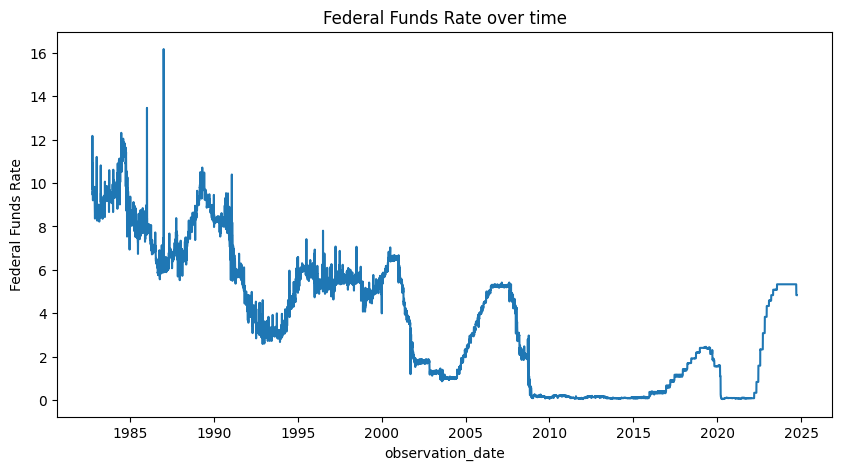

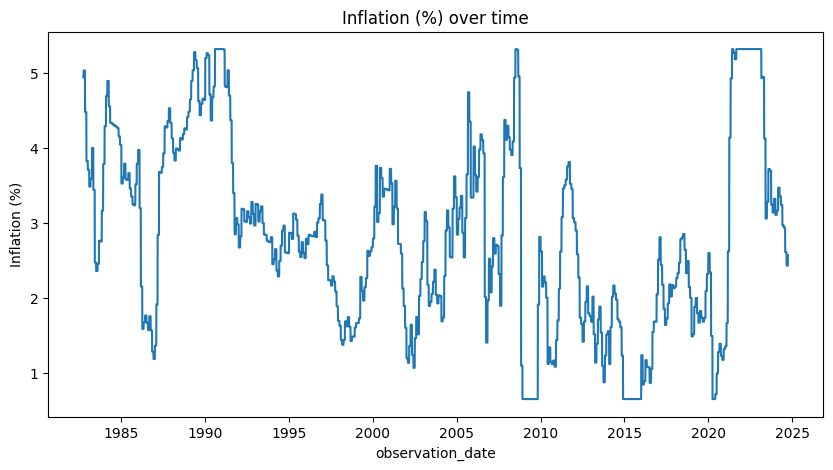

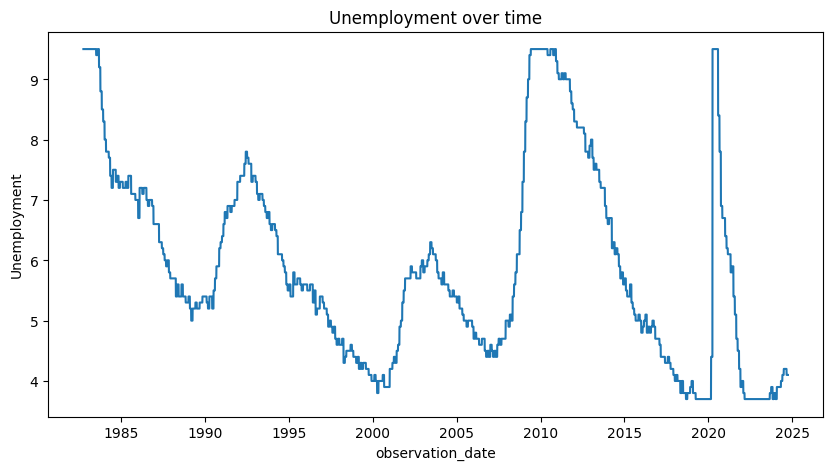

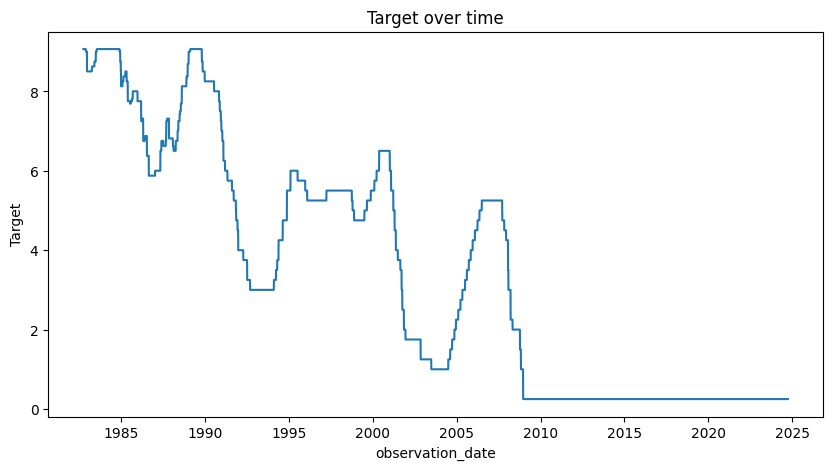

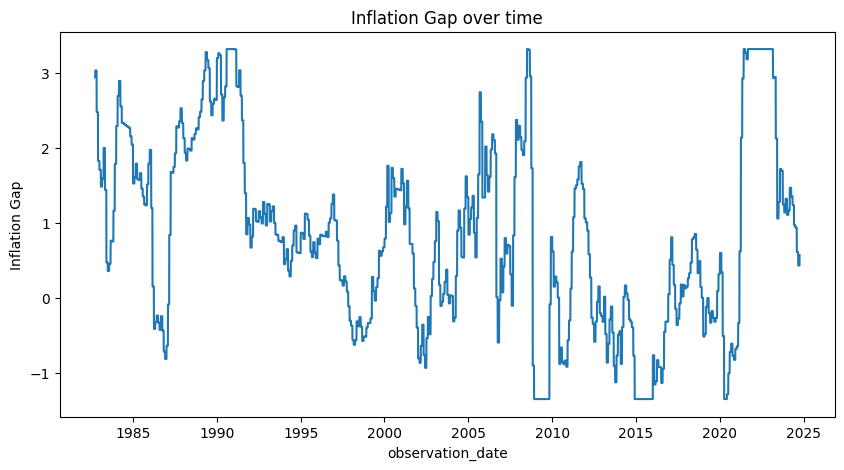

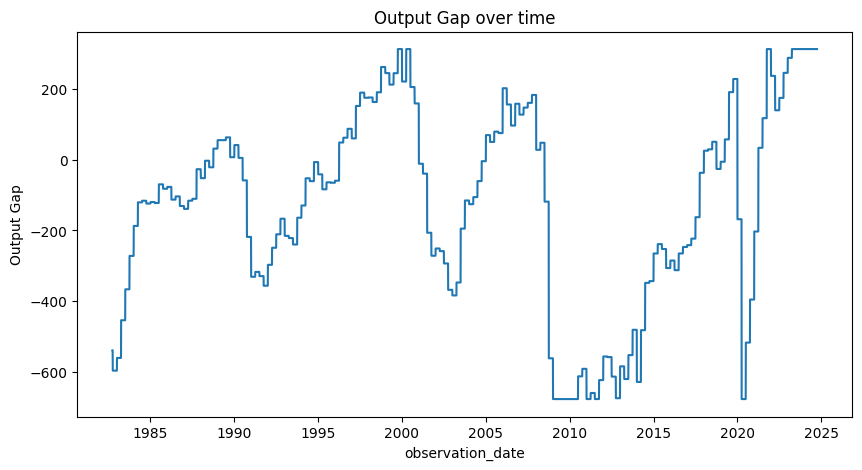

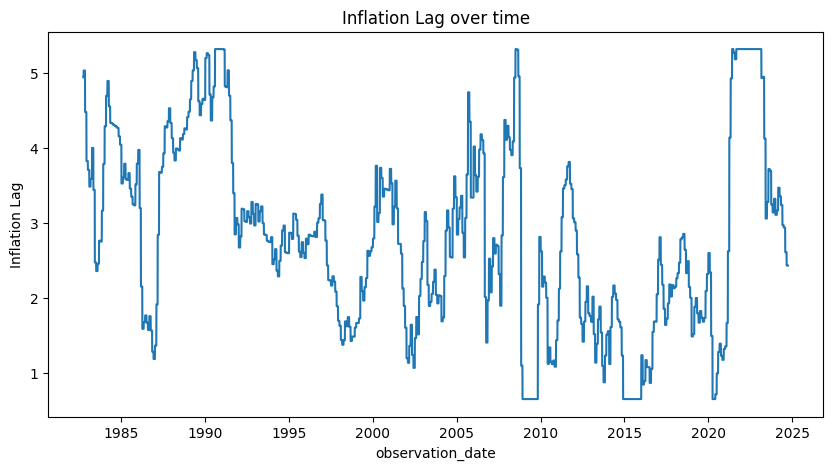

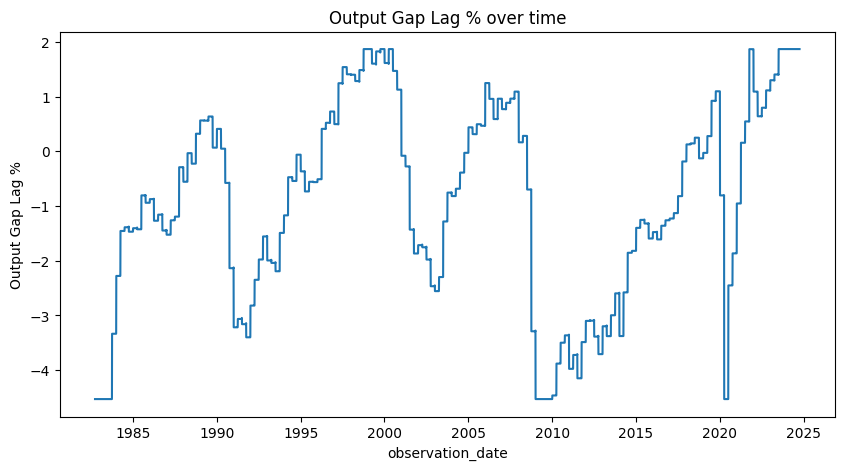

In [17]:
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data = df, x=df.index, y=df[column])
    plt.title(f"{column} over time")
    plt.show()

The Federal Funds Rate and the Target have been steadily decreasing since the 1980s. 

Inflation, Output Gap, and Unemployment have roughly remained around a constant level over time, despite having some sharp rises or drops.

## Distribution Plots

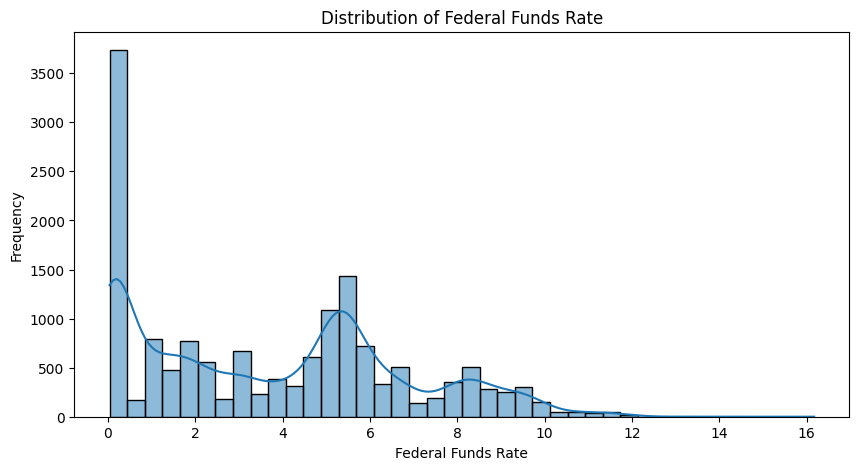

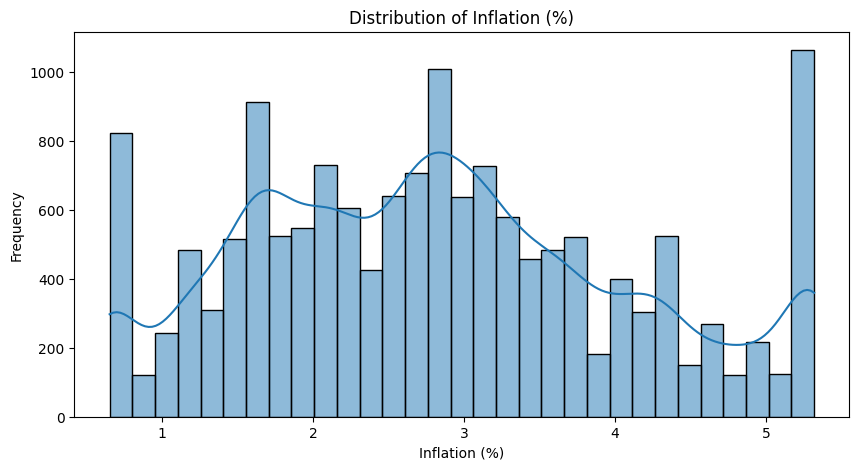

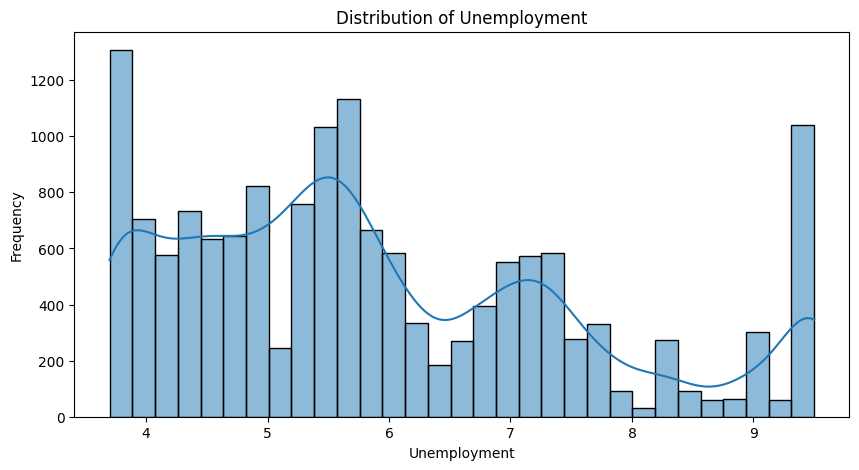

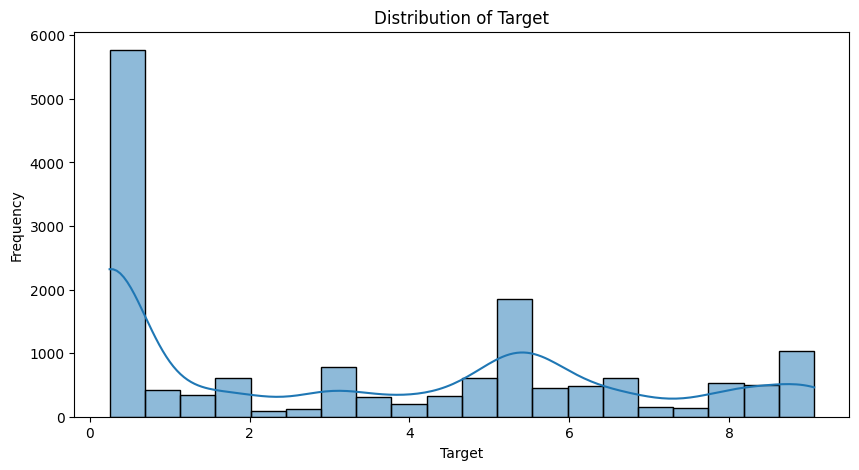

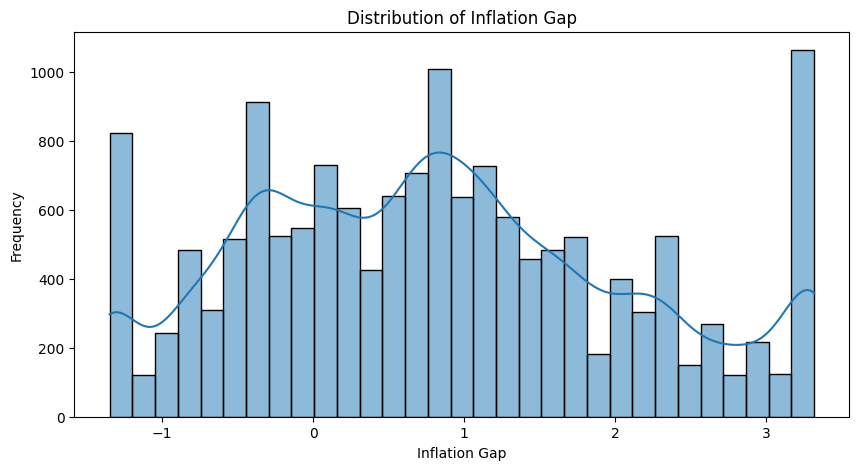

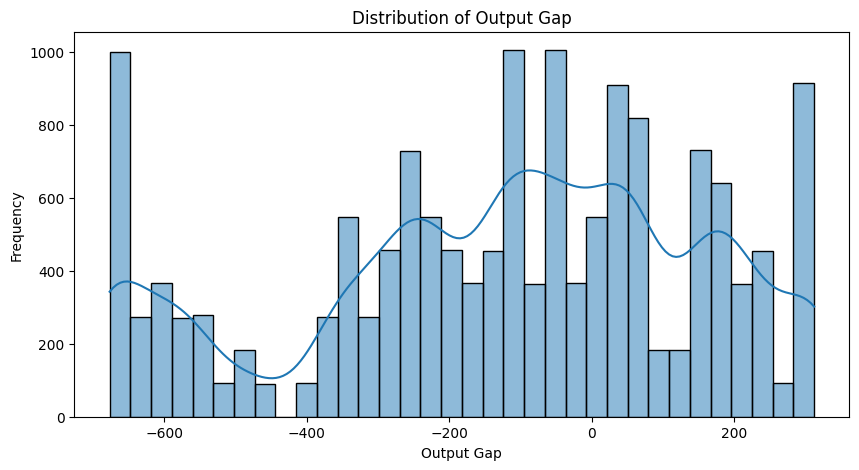

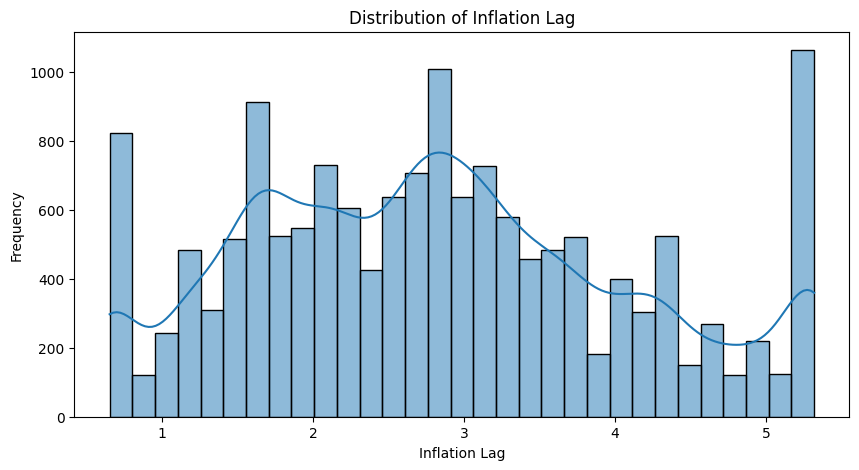

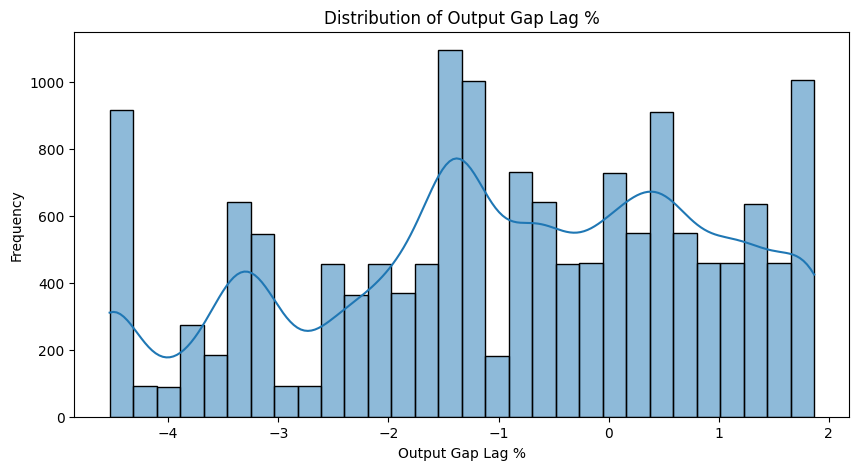

In [18]:
# Loop through columns to plot distributions
for column in df.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

None of the distributions are normal. Some are skewed and others are multimodal.

## Correlation Heatmap

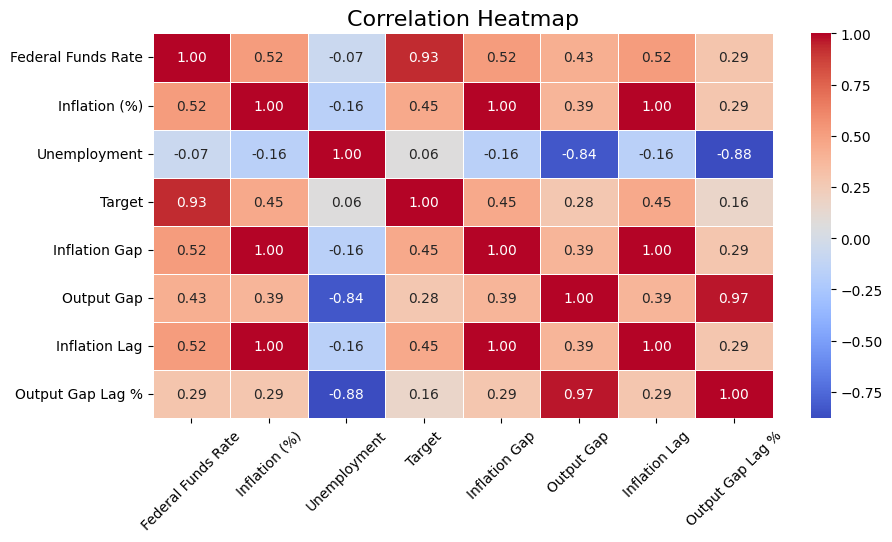

In [19]:
# Construct a Correlation Heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(
    df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
)
plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.show()

Inflation, Inflation Gap, and Inflation Lag are perfectly correlated to each other, while Output Gap and Output Gap Lag (%) are very strongly correlated, which is expected. We will not be trying any models that use more than 1 in each set as predictors at a time.

Unemployment and Output Gap are strongly correlated, so we will need to watch out for these when checking the Variance Inflation Factors (VIFs) for multicollinearity issues.

Target is highly correlated with our dependent variable, Federal Funds Rate, and we expect it to have the biggest impact on predictive performance of the model. Other features generally have between 40% and 50% correlation with the dependent variable, which is moderate. Unemployment has almost 0 correlation with the dependent variable which could mean low impact on predictive performance or a non-linear relationship. 

# OLS Modeling

The variables used for each regression Model are listed as follows:

Taylor's Rule Model: 

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap

Karakas Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap Lag %, Inflation Lag (%)
    
Target Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target
    
Unemployment Model:

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Unemployment
    
Both Model (uses both Unemployment and Target):

    Dependent variable: Federal Funds Rate. 
    Independent variables: Output Gap, Inflation Gap, Target, Unemployment

In [20]:
# Apply MinMaxScaler to independent variables
scaler = MinMaxScaler()
df_vars = ["Unemployment", "Target", "Inflation Gap", "Output Gap", "Output Gap Lag %", "Inflation Lag"]
df[df_vars] = scaler.fit_transform(df[df_vars])

The data should be scaled since we have numerical values of varying magnitudes. MinMaxScaler is chosen since it doesn't make the assumption that the distribution is normal, which StandardScaler does. RobustScaler is not used because we handled outliers already. 

## Fitting the Models

We will be using Ordinary Least Squares (OLS) to fit the models.

In [21]:
# Set dependent variable
y = df["Federal Funds Rate"]

# Define independent variables for each model
model_features = {
    "Taylor": df[["Output Gap", "Inflation Gap"]],
    "Karakas": df[["Output Gap Lag %", "Inflation Lag"]],
    "Target": df[["Output Gap", "Inflation Gap", "Target"]],
    "Unemployment": df[["Output Gap", "Inflation Gap", "Unemployment"]],
    "Both": df[["Output Gap", "Inflation Gap", "Target", "Unemployment"]],
}

# Initialize dictionaries to store results
ols_fitted_models = {}
ols_predictions = {}
ols_vif_results = {}
ols_error_metrics = {}

# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in model_features.items():
    X = sm.add_constant(X)
    
    # Fit the model
    model, y_pred = fit_ols_model(X, y, model_name)
    ols_fitted_models[model_name] = model
    ols_predictions[model_name] = y_pred

    # Calculate VIF
    vif_data = calculate_vif(X, model_name)
    ols_vif_results[model_name] = vif_data
   
    # Calculate error metrics
    metrics = error_metrics(y, y_pred)
    ols_error_metrics[model_name] = metrics

## OLS Regression Assumptions

In [22]:
# Dictionary to store assumption test results
ols_assumption_tests = {}
ols_residuals = {}

# Iterate through models
for model_name, model in ols_fitted_models.items():
    residuals = model.resid
    X = model.model.exog

    # Normality Tests (Jarque Bera)
    jb_test = jarque_bera(residuals)

    # Homoscedasticity Test (Breusch-Pagan)
    bp_test = het_breuschpagan(residuals, X)

    # Independence Test (Durbin-Watson)
    dw_stat = sm.stats.durbin_watson(residuals)

    # Linearity Tests (Rainbow)
    rainbow = linear_rainbow(model)

    # Store results
    ols_assumption_tests[model_name] = {
        "Durbin-Watson Test Statistic": f"{dw_stat:.4f}",
        "Jarque-Bera p-value": f"{jb_test[1]:.4f}",
        "Breusch-Pagan p-value": f"{bp_test[1]:.4f}",
        "Rainbow Test p-value": f"{rainbow[1]:.4f}"
    }
    
# Print assumption test statistics for all models  
ols_assumption_tests_df = pd.DataFrame(ols_assumption_tests).T.round(4)
ols_assumption_tests_df

,Durbin-Watson Test Statistic,Jarque-Bera p-value,Breusch-Pagan p-value,Rainbow Test p-value
Taylor,0.0071,0.0000,0.0000,0.0000
Karakas,0.0069,0.0000,0.0000,0.0000
Target,0.0445,0.0000,0.0000,0.0000
Unemployment,0.0109,0.0000,0.0000,0.0000
Both,0.0459,0.0000,0.0000,0.0000


The assumptions of regression include:

Normality of residuals
Homoscedasticity (constant variance of residuals)
Independence (autocorrelation)
Linearity
No Multicollinearity
These assumptions can be tested using the Jarque-Bera test (Normality), Breusch-Pagan test(Homoscedasticity), Durbin-Watson test (Independence), and Rainbow test (Linearity). For every model, the above p-values are all below the significance level and the Durbin Watson test statistic lies between 0 and 0.5.

Null Hypothesis, H0: The model does not violate the regression assumption

Alternative Hypothesis, H1: The model does violate the regression assumption

Using the 95% confidence level (significance level 0.05), the Jarque-Bera test, Breusch-Pagan test, and Rainbow test statistics all have p-values of around 0, which is less than the significance level.

Therefore, we would reject the null hypothesis, H0, in favor of the alternative and conclude that the models violate the assumptions for these tests.

For the Durbin-Watson test, statistics less than 1 or greater than 3 indicate strong autocorrelation and would violate the regression assumption of independence.

The models violates the first 4 regression Assumptions, which makes any metrics unreliable.

In [23]:
# Combine VIF results into a single DataFrame
all_vifs = []

for model_name, vif_df in ols_vif_results.items():
    vif_df = vif_df.copy()
    vif_df["Model"] = model_name
    all_vifs.append(vif_df)

# Concatenate all into one DataFrame and round
ols_vif_results_df = pd.concat(all_vifs, ignore_index=True)
ols_vif_results_df = ols_vif_results_df.round(4)

# Pivot table
ols_vif_results_df = ols_vif_results_df.pivot(index="Feature", columns="Model", values="VIF").round(4)

# Rearrange columns
ols_vif_results_df = ols_vif_results_df[["Taylor", "Karakas", "Target", "Unemployment", "Both"]]

# Print table of VIFs for all models  
ols_vif_results_df

Model,Taylor,Karakas,Target,Unemployment,Both
Feature,,,,,
Inflation Gap,1.1778,NaN,1.3848,1.3082,1.4085
Inflation Lag,NaN,1.0887,NaN,NaN,NaN
Output Gap,1.1778,NaN,1.1964,4.2165,5.5812
Output Gap Lag %,NaN,1.0887,NaN,NaN,NaN
Target,NaN,NaN,1.2739,NaN,1.7020
Unemployment,NaN,NaN,NaN,3.6800,4.9166
const,5.9301,6.4245,5.9413,34.7962,43.7499


From the VIFs, we do not have serious problems with multicollinearity except for the Output Gap in the Both Model. The best practice would to remove that from the model entirely, but since all other regression assumptions have been violated we will leave it and run the regression anyway. Unemployment, the other variable of interest from our correlation matrix analysis, has acceptable multicollinearity levels.

## Taylor and Karakas OLS Model Comparison

While all the regression assumptions except for Multicollinearity were violated and the results are unreliable, we can still compare our visualizations and metrics to Karakas's results and check if we reproduced their regression models, which is one objective of this project.

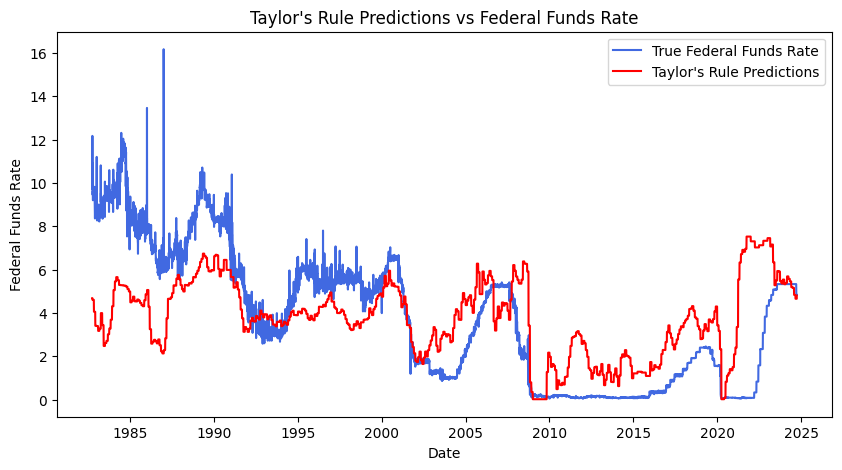

In [24]:
# Taylor Predictions vs Actual Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions["Taylor"], label=f"{"Taylor"}'s Rule Predictions", color="red")
plt.title(f"{selected_model}'s Rule Predictions vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

Consistent with Karakas' plots, we see our Taylor Model underpredicting in year 1990, briefly overpredicting between 1990 and 1995, before underpredicting until a bit past 2000. Around year 2002, the model begins overpredicting for the rest of the years, except between 2005 and 2010 where it underpredicts where the actual values form a peak and around 2008 or 2009. The plots may not be an exact match but they look similar enough to the ones shared in Karakas' paper.

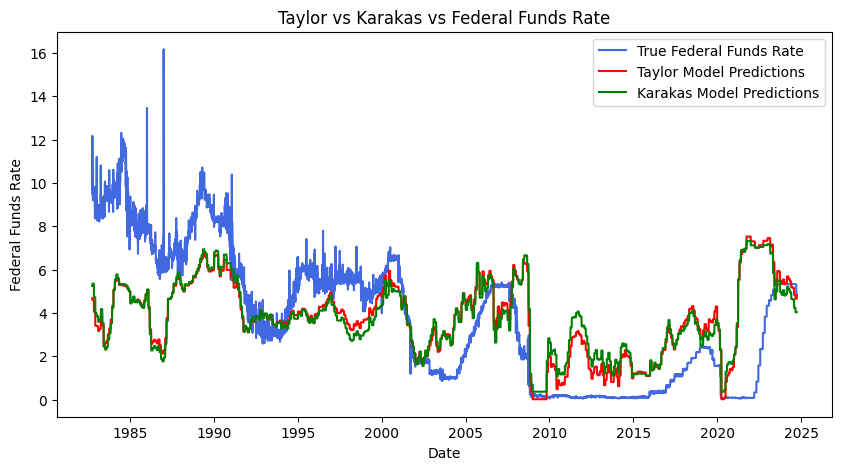

In [25]:
# Taylor Predictions vs Karakas Predictions vs Actual Plot
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
plt.plot(df.index, ols_predictions["Taylor"], label="Taylor Model Predictions", color="red")
plt.plot(df.index, ols_predictions["Karakas"], label="Karakas Model Predictions", color="green")
plt.title("Taylor vs Karakas vs Federal Funds Rate")
plt.xlabel("Date")
plt.ylabel("Federal Funds Rate")
plt.legend()
plt.show()

We capture similar patterns such as the Karakas Model underpredicting more than Taylor Model between 1997 to 2001 and mostly between 2010 and 2015, where there are 2 cross overs as they switch between overpredicting or underpredicting each other.

In [26]:
taylor_and_karakas = ["Taylor", "Karakas"]
for model in taylor_and_karakas:
    rs = find_resid_sum(y, ols_predictions[model])
    sae = find_sae(y, ols_predictions[model])
    print(f"{model}: ")
    print(f"\tSum of Residuals: {rs}")
    print(f"\tSum of Absolute Errors: {sae:.4f}")

Taylor: 
	Sum of Residuals: -1.8189894035458565e-11
	Sum of Absolute Errors: 29358.7040
Karakas: 
	Sum of Residuals: 1.4551915228366852e-11
	Sum of Absolute Errors: 31029.3788


We got much smaller Sum of Residuals than Karakas did and obtained larger Sum of Absolute Errors for both models. Additionally, we received lower values for each in the Taylor Model than the Karakas Model.

That being said, both metrics for each model are very close to each other, which implies that there isn't much of a difference in performance between the two models and is consistent with Karakas' findings.

## OLS Model Metrics

In [28]:
ols_error_metrics_df = pd.DataFrame(ols_error_metrics).T.round(4)
ols_error_metrics_df

,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Percentage Error,Mean Absolute Percentage Error,R-Squared
Taylor,6.217,2.493,1.913,-473.933,504.281,0.3277
Karakas,6.574,2.564,2.022,-550.486,579.147,0.2892
Target,0.884,0.940,0.605,-78.489,117.299,0.9044
Unemployment,4.573,2.138,1.669,-416.232,502.970,0.5056
Both,0.864,0.930,0.600,-85.274,119.014,0.9066


The error metrics show the Taylor Model having better performance over the Karakas Model. Karakas (2023) claimed that their model had more accurate predictions, but not by much.

We, on the other hand, found that the Taylor model has better predictions. Note that we have a different date range than Karakas, and this could mean that Karakas' model better predicts older data, but performs poorly on more recent data. Overall, their model does not perform as well as the Taylor Model, having larger average errors and percentage errors. The difference, however, is not very big, which is consistent with Karakas' findings.

All models have negative Mean Percentage Errors, and thus they all underpredict the Federal Funds Rate. The percentage error metrics seem to be very high. This is likely because due to our data having small values. Average error metrics would be better for analysis.

In terms of performance, the models from worst to best are:

Karakas < Taylor < Unemployment < Target < Both

Models with lower error metrics and higher R-squared are considered better performing than others.

Adding Target or Unemployment alone to the Taylor Model increases performance, but there are marginal differences in performance when adding Unemployment alongside the Target. This suggests that Unemployment contributes little to the model, consistent with the findings from the correlation heatmap.

Note that metrics are likely biased and unreliable since regression assumptions have been violated.



In [27]:
# Initialize a list to store model statistics
model_statistics = []

# Loop through the fitted models to extract key statistics
for model_name, model in ols_fitted_models.items():
    # Extract key values
    results = {
        "model": model_name,
        "adj_r_squared": round(model.rsquared_adj, 3),
        "aic": round(model.aic, 3),
        "bic": round(model.bic, 3),
        "f_stat": round(model.fvalue, 3),
        "f_p_value": round(model.f_pvalue, 3),
        "t_p_values": model.pvalues.round(3).tolist(),
    }
    # Append the results for each model
    model_statistics.append(results)

# Convert results to a DataFrame
statistics = pd.DataFrame(model_statistics)
statistics

,model,adj_r_squared,aic,bic,f_stat,f_p_value,t_p_values
0,Taylor,0.328,71598.369,71621.285,3739.751,0.0,"[0.728, 0.0, 0.0]"
1,Karakas,0.289,72453.922,72476.837,3120.973,0.0,"[0.0, 0.0, 0.0]"
2,Target,0.904,41668.118,41698.673,48379.575,0.0,"[0.0, 0.0, 0.0, 0.0]"
3,Unemployment,0.505,66885.511,66916.065,5228.964,0.0,"[0.0, 0.0, 0.0, 0.0]"
4,Both,0.907,41308.066,41346.259,37240.048,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


Generally speaking, a model with lower values for AIC and BIC would be better than a model with higher values for them. The AIC and BIC show a similar pattern to our findings from the error metrics and R-squared, with the models listed from worst performing to best performing being:

Karakas < Taylor < Unemployment < Target < Both.

The p-values for the f-statistic and t-statistic suggests the models and coefficients are almost all statistically significant from a simple hypothesis test where the null hypothesis, H0, is that the models/coefficients are not significant. The exception is the constant from the Taylor Model which would not be statistically significant.

Note that metrics are likely biased and unreliable since regression assumptions have been violated.

# Neural Network Model

## Fitting the Models

In [29]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42) 
tf.random.set_seed(42)

# Initialize dictionaries to store results
nn_fitted_models = {}
nn_predictions = {}
nn_error_metrics = {}
nn_history = {}
# Loop to fit, calculate VIFs, Calculate error metrics, and extract model stats for all models
for model_name, X in model_features.items():
    # Fit the model
    model, y_pred, history = fit_nn_model(X, y, model_name)
    
    nn_fitted_models[model_name] = model
    
    # Obtain predictions
    nn_predictions[model_name] = y_pred
    
    # Find model metrics
    metrics = error_metrics(y, y_pred)
    nn_error_metrics[model_name] = metrics

    # Save model training history
    nn_history = history

480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step


## Neural Network Model Metrics

In [30]:
nn_error_metrics_df = pd.DataFrame(nn_error_metrics).T.round(4)
nn_error_metrics_df

,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Mean Percentage Error,Mean Absolute Percentage Error,R-Squared
Taylor,6.978,2.642,2.191,-635.237,661.376,0.2455
Karakas,7.104,2.665,2.168,-693.999,715.020,0.2319
Target,1.011,1.005,0.613,-72.375,129.459,0.8907
Unemployment,6.426,2.535,2.166,-696.731,720.984,0.3051
Both,1.063,1.031,0.657,-118.800,156.094,0.8851


Our models have returned worse results for each metric compared to the OLS models. The regression assumptions being violated may have inflated the OLS model metrics. Our model performance ranking differs slightly here.

We now have from worst performing to best performing:

Karakas < Taylor < Unemployment < Both < Target.

Like with the OLS models, we find that there is little difference in performance between the Karakas and Taylor Models.

All models have negative Mean Percentage Errors, meaning that all of the models underpredict the Federal Funds Rate.

The inclusion of both the Target and Unemployment into the Taylor Model raised the R-squared from around 0.24 to around 0.89, which is very strong performance for a model using real economic data. However, there is not much of a difference between the performance of the Target Model and the Both Model in average errors or R-squared. On the other hand, the MPE and MAPE have differences of around 27% to 40%. These values are likely high due to our data having small values. Average error metrics would be better for analysis.

Adding Unemployment to the Taylor Model alone reduces errors and explains more variance but increases percentage errors. Unemployment contributes little when added with the Target.

## Neural Network Prediction Plots

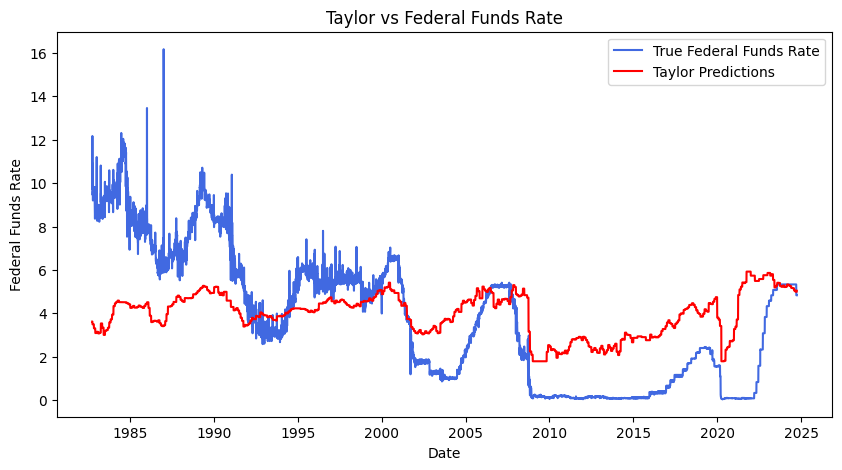

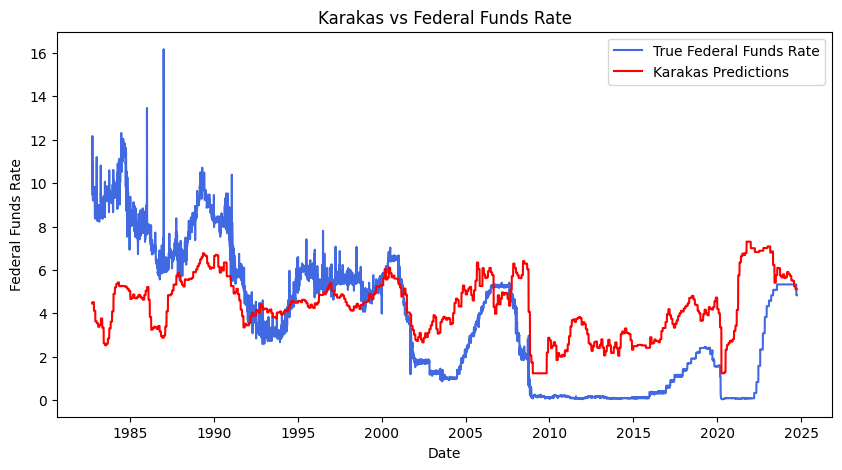

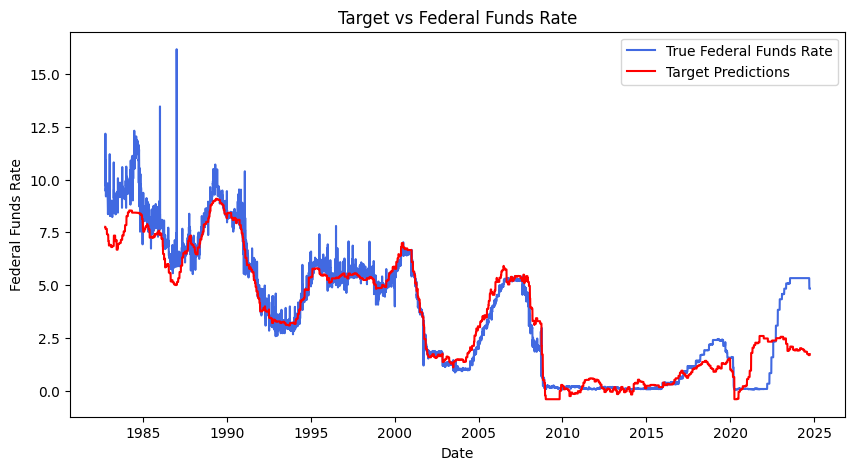

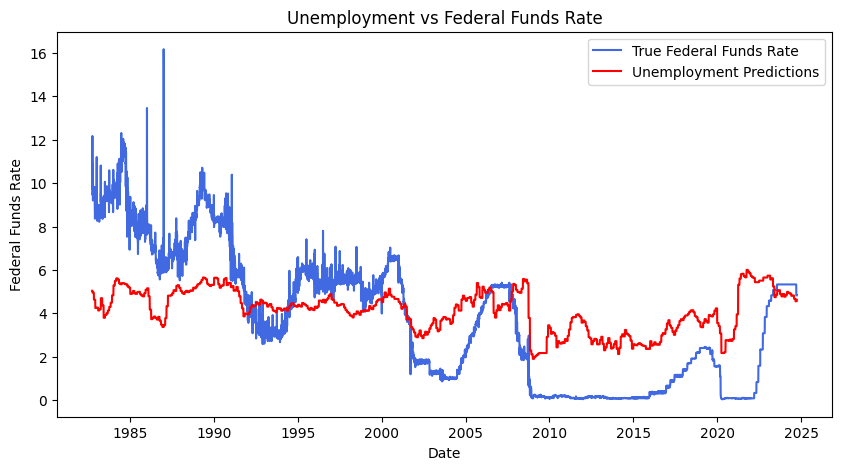

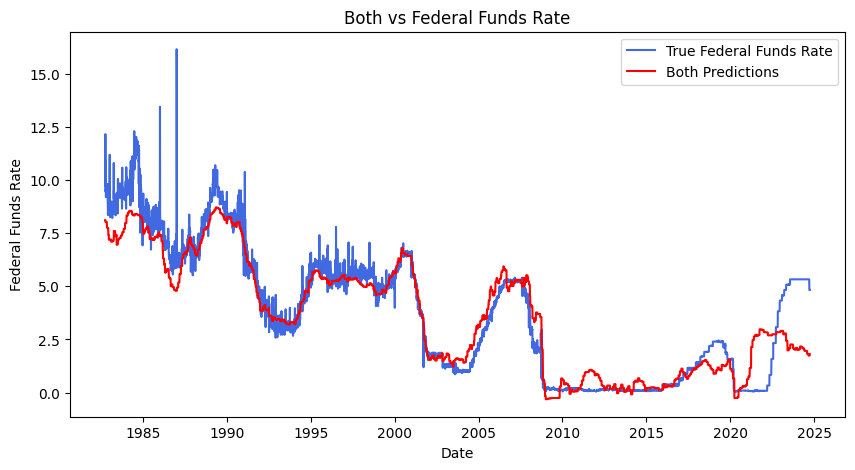

In [31]:
# Plot all neural network model predictions
for model_name, y_pred in nn_predictions.items():
    nn_predictions[model_name] = y_pred
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, y, label="True Federal Funds Rate", color="royalblue")
    plt.plot(df.index, y_pred, label=f"{model_name} Predictions", color="red")
    plt.title(f"{model_name} vs Federal Funds Rate")
    plt.xlabel("Date")
    plt.ylabel("Federal Funds Rate")
    plt.legend()
    plt.show()

# Conclusion

Although the results may differ due to different date ranges in our data, our models captured similar predictive patterns to those presented in Karakas' paper from our examination of the plots as well as the Sum of Residuals and Sum of Absolute Errors.

Karakas (2023) noted that the Taylor Model (and their transformation of it) did not predict the FFR well and mentioned their model having predictions closer to the actual Federal Funds Rate than the Taylor Model, but not by much. However, our models' metrics show that it is the Taylor Model, rather than Karakas' Model that has smaller average errors and percentage errors. We suspect this may be due to how the data we use contains more recent data. Also, our plot of the Taylor Model predictions does not have any predictions below 0 unlike Karakas' plot. This may be because Karakas did not handle outliers well or at all.

We noticed that Karakas did not mention regression assumptions in their paper when discussing their OLS models, so we decided to check them as part of the validation process. We found that almost all classical regression assumptions were violated, with the exception being multicollinearity.

Karakas later created neural network models for using Taylor's Rule, getting better predictions than their OLS models. From our findings, the OLS models had inflated metrics due to regression assumption violations. Our neural network models, on the other hand, had lower performance metrics than our OLS models. Since Karakas got better results from their neural network model than their OLS model which should also have inflated metrics, their neural network is likely to have issues with overfitting given that they did not mention usage of techniques such as regularization, dropout, or early stopping like we had for our models.

This casts serious doubts on the credibility, rigor, professionalism of their work.

We believe that non-linear models are better suited for predicting the Federal Funds Rate given that no feature we used had a linear relationship with the Federal Funds Rate.

It is worth noting that the inclusion of Target and Unemployment to the Taylor Model, individually, did improve performance metrics in both the OLS and Neural Network Models. However, the Target has a much larger effect on model performance than Unemployment and Unemployment has little effect on performance when it is alongside the Target.

While performance metrics look strong for the Target Model, there is room for improvement. Some next steps would be to explore interaction terms with alongside Unemployment or taking lags of Unemployment to avoid multicollinearity issues with Output Gap. The addition of other features such as Global Economic Growth, Prices, Interest rates, Foreign Currency Exchange Rates, Consumer Confidence, and Business Confidence are also worth exploring.

# References

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Effective Rate [DFF]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFF

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Rate (DISCONTINUED) [DFEDTAR]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTAR

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Lower Limit [DFEDTARL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARL

Board of Governors of the Federal Reserve System (US). (2025). Federal Funds Target Range - Upper Limit [DFEDTARU]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/DFEDTARU

Karakas, A. D. (2023). Reevaluating the Taylor Rule with Machine Learning. ArXiv.org. https://arxiv.org/abs/2302.08323

U.S. Bureau of Economic Analysis. (2025). Real Gross Domestic Product [GDPC1]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPC1

U.S. Bureau of Labor Statistics. (2025). Consumer Price Index for all urban consumers: All items in U.S. city average [CPIAUCSL]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/CPIAUCSL

U.S. Bureau of Labor Statistics. (2025). Unemployment Rate [UNRATE]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/UNRATE

U.S. Congressional Budget Office. (2025). Real Potential Gross Domestic Product [GDPPOT]. Federal Reserve Bank of St. Louis. https://fred.stlouisfed.org/series/GDPPOT